In [3]:
%load_ext autoreload
%autoreload 2

import matplotlib.style as style

import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

import scqubits as scq
import qutip as qt

from PulseSequence import PulseSequence
from QSwitch import QSwitch

style.use('default')
plt.rcParams['figure.figsize'] = [9.7, 6]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# scq.settings.PROGRESSBAR_DISABLED = True

In [4]:
hbar = 1.054e-34
h = hbar*2*np.pi
qe = 1.602e-19
red_flux_quant = hbar/2/qe 

# Unit conversions
MHz = 10.0**(-3)
GHz = 1.0
kHz = 10.0**(-6)
us = 10.0**3
ns = 1.0

In [5]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def show_mat_2d(mat, ax, title, labels, cmax=1, show=True):
    """
    Plot an arbitrary 2D matrix with labels
    """
    plt.sca(ax)
    plt.title(title)
    plt.imshow(np.real(mat), cmap='RdBu')
    # hinton(np.real(mat), xlabels=labels, ylabels=labels)
    plt.xticks(np.arange(len(mat)), labels)
    plt.yticks(np.arange(len(mat)), labels)
    # Loop over data dimensions and create text annotations.
    for ii in range(len(mat)):
        for jj in range(len(mat)):
            plt.text(ii, jj, round(mat[jj, ii], 3), ha="center", va="center", color="w", size=11)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cax=cax)
    plt.clim(vmin=-cmax, vmax=cmax)
    plt.tight_layout()
    if show: plt.show()

def show_plot_rho_2d(rho_id, title=None, cmax=None):
    """
    Plot real and imag parts of rho, optionally also with a comparison ideal rho
    """
    labels = ["00", "01", "10", "11"]
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    plt.suptitle(title)
    if cmax is None: cmax = np.max(np.abs(np.array([np.real(rho_id), np.imag(rho_id)])))
    show_mat_2d(np.real(rho_id), ax=ax1, title="Re[$\\rho_{Ideal}$]", labels=labels, cmax=cmax, show=False)
    show_mat_2d(np.imag(rho_id), ax=ax2, title="Im[$\\rho_{Ideal}$]", labels=labels, cmax=cmax, show=False)
    plt.show()

# Set qubit parameters

In [6]:
# q_in, q_switch, q_out1, q_out2

# EJs = [13.41, 12.52, 8.94, 12.52]
# EJs = [12.109, 11.195, 7.997, 11.195]
# EJs = [17.523, 16.450, 11.622, 16.450]

# ECs = [0.237, 0.133, 0.270, 0.215]

# gs = [0.0827, 0.0787, 0.0652] # g01, g12, g13
# gs = [1e-3*73.44448637160531, 1e-3*70.62005211780702, 1e-3*58.4998799537415]
# gs = [1e-3*88.68898701296644, 1e-3*85.3693409331001, 1e-3*70.91300299056793]
# gs = [0,0,0]
# gs = [1e-3*66.56542672271766, 1e-3*65.06457214018066, 1e-3*51.68752851908644]
# gs = [0.0613, 0.0600, 0.0475]

qubit_freqs = None
alphas = None


EJs = None
ECs = None
qubit_freqs = np.array([4146.29086881774893, 3464.7403852710677, 4806.4284729347243, 4426.85588770023173])*1e-3
# alphas = [-0.182, -0.108, -0.220, -0.168]
ef_freqs = np.array([4000-78.90376315971923, 3364.253, 4611.098326885819, 4254.36098271568733])*1e-3
alphas = ef_freqs - qubit_freqs
print(alphas)
gs = [0.054, 0.043, 0.040] # g01, g12, g13

[-0.22519463 -0.10048739 -0.19533015 -0.1724949 ]


# Analytical swap

In [7]:
cutoffs = [4, 5, 4, 4]
isCavity = [False, False, False, False]

qram = QSwitch(
    EJs=EJs,
    ECs=ECs,
    gs=gs,
    qubit_freqs=qubit_freqs,
    alphas=alphas,
    cutoffs=cutoffs,
    isCavity=isCavity,
)

qubit_freqs = qram.qubit_freqs
alphas = qram.alphas
print('qubit freqs (GHz)', *qubit_freqs)
print('alphas (GHz)', *alphas)
print('aprox sideband freqs (GHz)', 2*qubit_freqs[1] + alphas[1] - qubit_freqs)
print([qram.get_base_wd('ggeg', 'gfgg')/2/np.pi])


# print('capacitances (fF)', *(qe**2/(2*h*np.array(ECs)*1e9)*1e15))
# print('lumped L (nH)', *(red_flux_quant**2/h/np.array(EJs)))

qubit freqs (GHz) 4.146290868817749 3.464740385271068 4.806428472934725 4.426855887700231
alphas (GHz) -0.22519463197746825 -0.10048738527106771 -0.19533014604890564 -0.17249490498454456
aprox sideband freqs (GHz) [2.68270252 3.364253   2.02256491 2.4021375 ]
[2.008224865646821]


In [6]:
print('ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]')
print('Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)')
print(1e3*qram.get_ZZ_matrix())

ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]
Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)
[[ 0.         -5.05108095 -0.01781378 -0.13092895]
 [-5.05108095  0.         -0.65141241 -1.0196405 ]
 [-0.01781378 -0.65141241  0.         -0.02110892]
 [-0.13092895 -1.0196405  -0.02110892  0.        ]]


In [7]:
# MAKE SURE DRESSED STATES ARE MAPPED CORRECTLY, AT LEAST FOR <= n EXCITATIONS
# qram.check_state_mapping(n=3)

## Create pulse sequence

In [13]:
seq = PulseSequence(start_time=0)
# wd1 = qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.17)
# wd2 = qram.add_sequential_pi_pulse(seq, 'eegg', 'eggg', amp=0.01)
# wd3 = qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggeg', amp=0.08)
# wd4 = qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', wd=wd1, amp=0.17)
# wd5 = qram.add_sequential_pi_pulse(seq, 'ggeg', 'geeg', amp=0.01) # should be same as wd2
# wd6 = qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggge', amp=0.01)
# wd7 = qram.add_sequential_pi_pulse(seq, 'ggge', 'gege', amp=0.01) # should be same as wd2 and should also drive geeg -> ggeg


wd00 = qram.add_sequential_pi_pulse(seq, 'gggg', 'eggg', amp=0.01, drive_qubit=0, type='gauss')
wd01 = qram.add_sequential_pi_pulse(seq, 'eggg', 'eegg', amp=0.01, pihalf=True, drive_qubit=1, phase=-np.pi/2, type='gauss')

# ---- FORWARD PROTOCOL ---- 
print('wd0')
wd0 = qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.08, drive_qubit=1)
print('wd1')
wd1 = qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggeg', amp=0.08, drive_qubit=1)
print('wd2')
wd2_1 = qram.get_wd('eegg', 'eggg', amp=0.01, drive_qubit=1, verbose=True)
wd2_2 = qram.get_wd('ggeg', 'geeg', amp=0.01, drive_qubit=1, verbose=True)
wd2_3 = qram.get_wd('gegg', 'gggg', amp=0.01, drive_qubit=1, verbose=True)
wd2 = qram.add_sequential_pi_pulse(seq, 'eegg', 'eggg', amp=0.01, drive_qubit=1, 
                                   wd=np.average((wd2_1, wd2_2, wd2_3)), type='gauss')
# wd2 = qram.add_sequential_pi_pulse(seq, 'eegg', 'eggg', amp=0.01, drive_qubit=1, type='gauss')
print('wd3')
wd3 = qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.08, drive_qubit=1, wd=wd0)
print('wd4')
wd4 = qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggge', amp=0.08, drive_qubit=1)
print('wd5')
wd5_1 = qram.get_wd('ggge', 'gege', amp=0.01, drive_qubit=1, verbose=True)
wd5_2 = qram.get_wd('geeg', 'ggeg', amp=0.01, drive_qubit=1, verbose=True)
wd5_3 = qram.get_wd('gegg', 'gggg', amp=0.01, drive_qubit=1, verbose=True)
wd5 = qram.add_sequential_pi_pulse(seq, 'ggge', 'gege', amp=0.01, 
                                   drive_qubit=1, wd=np.average((wd5_1, wd5_2, wd5_3)), type='gauss')
# wd5 = qram.add_sequential_pi_pulse(seq, 'ggge', 'gege', amp=0.01, drive_qubit=1, type='gauss')

# # ---- REVERSE PROTOCOL ---- 
# print('wd5')
# qram.add_sequential_pi_pulse(seq, 'ggge', 'gege', amp=0.01, 
#                                    drive_qubit=1, wd=np.average((wd5_1, wd5_2, wd5_3)), type='gauss')
# # qram.add_sequential_pi_pulse(seq, 'ggge', 'gege', amp=0.01, drive_qubit=1, wd=wd5, type='gauss')
# print('wd4')
# qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggge', amp=0.08, drive_qubit=1, wd=wd4)
# print('wd3')
# qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.08, drive_qubit=1, wd=wd0)
# print('wd2')
# qram.add_sequential_pi_pulse(seq, 'eegg', 'eggg', amp=0.01, drive_qubit=1, 
#                                    wd=np.average((wd2_1, wd2_2, wd2_3)), type='gauss')
# # qram.add_sequential_pi_pulse(seq, 'eegg', 'eggg', amp=0.01, drive_qubit=1, wd=wd2, type='gauss')
# print('wd1')
# qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggeg', amp=0.08, drive_qubit=1, wd=wd1)
# print('wd0')
# qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.08, drive_qubit=1, wd=wd0)

# wd2_1 = qram.get_wd('eegg', 'eggg', amp=0.01, drive_qubit=1, verbose=True)
# wd2_2 = qram.get_wd('ggeg', 'geeg', amp=0.01, drive_qubit=1, verbose=True)
# wd2_3 = qram.get_wd('gegg', 'gggg', amp=0.01, drive_qubit=1, verbose=True)
# wd2 = qram.add_sequential_pi_pulse(seq, 'eegg', 'eggg', amp=0.01, drive_qubit=1, 
#                                    wd=np.average((wd2_1, wd2_2, wd2_3)))
# print('wd5')
# wd5_1 = qram.get_wd('ggge', 'gege', amp=0.01, drive_qubit=1, verbose=True)
# wd5_2 = qram.get_wd('geeg', 'ggeg', amp=0.01, drive_qubit=1, verbose=True)
# wd5_3 = qram.get_wd('gegg', 'gggg', amp=0.01, drive_qubit=1, verbose=True)
# wd5 = qram.add_sequential_pi_pulse(seq, 'ggge', 'gege', amp=0.01, 
#                                    drive_qubit=1, wd=np.average((wd5_1, wd5_2, wd5_3)))

# print('wd0')
# wd0 = qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.08, drive_qubit=1)
# print('wd1')
# wd1 = qram.add_sequential_pi_pulse(seq, 'eegg', 'eggg', amp=0.01, drive_qubit=1)
# print('wd2')
# wd2 = qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggeg', amp=0.08, drive_qubit=1)
# print('wd3')
# wd3 = qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.09, drive_qubit=1, wd=wd0)
# # wd4 = qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.05, drive_qubit=0, wd=wd1)
# print('wd4')
# wd4 = qram.add_sequential_pi_pulse(seq, 'ggeg', 'geeg', amp=0.01, drive_qubit=1)
# print('wd5')
# wd5 = qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggge', amp=0.10, drive_qubit=1)
# print('wd6')
# wd6_1 = qram.get_wd('ggge', 'gege', amp=0.01, drive_qubit=1, verbose=True)
# wd6_2 = qram.get_wd('geeg', 'ggeg', amp=0.01, drive_qubit=1, verbose=True)
# wd6 = qram.add_sequential_pi_pulse(seq, 'ggge', 'gege', amp=0.01, 
#                                    drive_qubit=1, wd=np.average((wd6_1, wd6_2)))


# wd6 = qram.add_sequential_pi_pulse(seq, 'ggge', 'gege', amp=0.0075, drive_qubit=1)
# print('wd7')
# wd8 = qram.add_sequential_pi_pulse(seq, 'geeg', 'ggeg', amp=0.01, drive_qubit=1)

# wd7_1 = qram.get_wd('ggge', 'gege', amp=0.01, drive_qubit=1, verbose=True)
# wd7_2 = qram.get_wd('geeg', 'ggeg', amp=0.01, drive_qubit=1, verbose=True)
# wd7 = qram.add_sequential_pi_pulse(seq, 'ggge', 'gege', amp=0.01, 
#                                    drive_qubit=1, wd=np.average((wd7_1, wd7_2)))
print('Done.')

	new overlap 0.9993700934494685 wd 26.07830048423359 wd_res 0.25
updated drive freq (GHz) from 4.150490429501544 to 4.150490429501544
	new overlap 0.9966926059893622 wd 21.69228652385475 wd_res 0.25
updated drive freq (GHz) from 3.4524346272371913 to 3.4524346272371913
wd0
	new overlap 0.7923486609427579 wd 16.748135059756176 wd_res 0.25
	new overlap 0.7923486609427579 wd 16.748135059756176 wd_res 0.05
	new overlap 0.9838826856091276 wd 16.738135059756175 wd_res 0.005
	new overlap 0.9887336221264085 wd 16.739135059756176 wd_res 0.001
	new overlap 0.9887336221264085 wd 16.739135059756176 wd_res 0.0002
	new overlap 0.9887403509713999 wd 16.739095059756178 wd_res 2e-05
	new overlap 0.988740441854348 wd 16.739099059756178 wd_res 4.000000000000001e-06
updated drive freq (GHz) from 2.6655484823308715 to 2.6641103582650936
wd1
	new overlap 0.781261551169166 wd 12.618048969344805 wd_res 0.25
	new overlap 0.781261551169166 wd 12.618048969344805 wd_res 0.05
	new overlap 0.781261551169166 wd 12.6

In [33]:
# CHECK FOR CLASHING LEVELS
tolerance = 100*MHz
problem_pulses = qram.check_level_resonances(seq, tolerance=tolerance)
good_freqs = seq.get_pulse_freqs(simplified=True)
print(good_freqs)
if len(problem_pulses.items()) == 0:
    print(f'No clashes found within {tolerance} GHz!')
for good_pulse, problem_pulse_dict in problem_pulses.items():
    print('Clashes to', tolerance,'GHz with', good_pulse[0], '<->', good_pulse[1], f'(freq = {good_freqs[good_pulse]})', 'tpi', qram.get_Tpi(good_pulse[0], good_pulse[1], amp=0.05))
    for problem_pulse, freq in problem_pulse_dict.items():
        diff_freq = np.abs(freq)-np.abs(good_freqs[good_pulse])
        if np.abs(diff_freq) > tolerance:
            diff_freq = 2*np.abs(freq)-np.abs(good_freqs[good_pulse])
        print('\t', 'GOOD PULSE' if problem_pulse in good_freqs.keys() else '', problem_pulse[0], '<->', problem_pulse[1], freq, f'(off by {diff_freq*1e3} MHz)', 'tpi', qram.get_Tpi(problem_pulse[0], problem_pulse[1], amp=0.05))

{('eggg', 'gfgg'): 2.6687646921233563, ('eegg', 'eggg'): 3.4554024335349194, ('gfgg', 'ggeg'): 2.0102602733899158, ('geeg', 'ggeg'): 3.45734192237418, ('gfgg', 'ggge'): 2.366858589161423, ('gege', 'ggge'): 3.4572826943995345}
Clashes to 0.1 GHz with eegg <-> eggg (freq = 3.4554024335349194) tpi 10.072254492517306
	  eegg <-> efgg -3.3579326071315307 (off by -97.46982640338864 MHz) tpi 7.108730619483111
	 GOOD PULSE geeg <-> ggeg 3.45734192237418 (off by 1.9394888392607612 MHz) tpi 10.036776548704886
	 GOOD PULSE gege <-> ggge 3.4572826943995345 (off by 1.8802608646151242 MHz) tpi 10.03963602738572
Clashes to 0.1 GHz with geeg <-> ggeg (freq = 3.45734192237418) tpi 10.036776548704886
	  geeg <-> gfeg -3.358692536929624 (off by -98.64938544455626 MHz) tpi 7.092286892751518
	 GOOD PULSE eegg <-> eggg 3.4554024335349194 (off by -1.9394888392607612 MHz) tpi 10.072254492517306
	 GOOD PULSE gege <-> ggge 3.4572826943995345 (off by -0.059227974645637005 MHz) tpi 10.03963602738572
Clashes to 0.

Plot pulse seq envelopes

[4.150490429501544, 3.4524346272371913, 2.6641103582650936, 2.0078269782890916, 3.4555848770716464, 2.6641103582650936, 2.3868131992378703, 3.456928690555302] (GHz)
[83.85067820034746, 42.28231517923382, 457.22540711934823, 2001.111586859929, 84.56463035846764, 457.22540711934823, 1142.2119369459901, 84.02983063045578] (ns)
total pulse length 4352.501792413121 ns


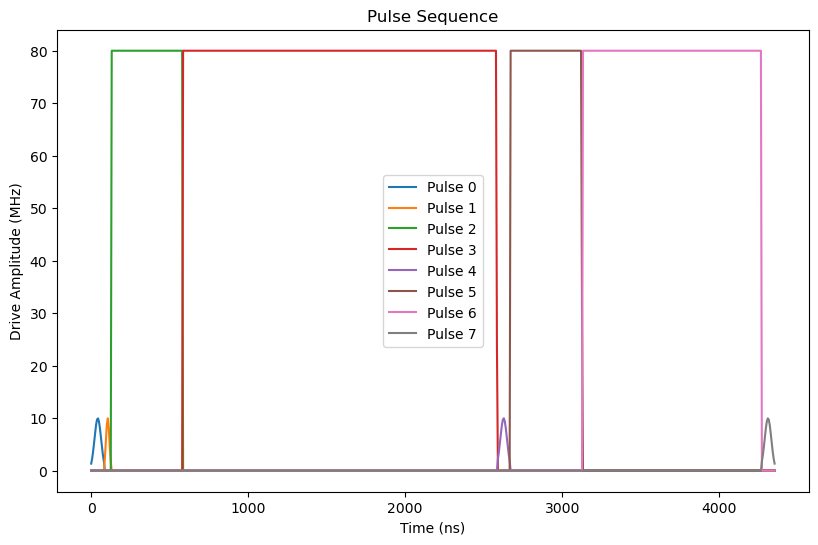

In [14]:

envelope_seq = seq.get_envelope_seq()
pulse_amps = seq.get_pulse_amps()
pulse_lens = seq.get_pulse_lengths()
print(seq.get_pulse_freqs(), '(GHz)')
print(pulse_lens, '(ns)')
print('total pulse length', sum(seq.get_pulse_lengths()), 'ns')

# times = []
# tot_time = 0
# for pulse_len in pulse_lens:
#     # times.append(np.linspace(tot_time, tot_time + pulse_len, 100))
#     nsteps = 50
#     dt = pulse_len/nsteps
#     if dt > 5: nsteps = int(pulse_len // 10)
#     times = np.append(times, np.linspace(tot_time, tot_time + pulse_len, nsteps))
#     tot_time = tot_time + pulse_len
# print('num time points', len(times))

times = np.linspace(0, sum(seq.get_pulse_lengths()), 700)
# times = np.linspace(0, sum(seq.get_pulse_lengths()), 50)

flat_times = np.array(times).flatten()
for i in range(len(envelope_seq)):
    plt.plot(flat_times, [pulse_amps[i]*envelope_seq[i](t)/MHz for t in flat_times], label=f'Pulse {i}')
plt.xlabel('Time (ns)')
plt.ylabel('Drive Amplitude (MHz)')
# plt.xlim(0, 200)
plt.title('Pulse Sequence')
plt.legend()
plt.show()

## Run simulation

In [67]:
T1 = 60e3 # ns
T2 = 30e3 # ?

# T1 = 10e3

# c_ops = [
#     np.sqrt(1/T1)*qram.a,
#     np.sqrt(1/T1)*qram.b,
#     np.sqrt(1/T1)*qram.c,
#     np.sqrt(1/T1)*qram.d,
# ]

c_ops = None

In [154]:
psi0 = result[-1]

In [15]:
# psi0_name = 'eggg'
# psi0_name = 'gfgg'
# psi0_name = 'efgg'
# psi0_name = 'eegg'
# psi0_name = 'ggeg'
# psi0_name = 'ggge'

# psi0 = qram.state(psi0_name)
psi0 = qram.state('gggg')
# psi0 = np.sqrt(0.5) * qram.state('eggg') + np.sqrt(0.5) * qram.state('eegg') # QRAM start
# psi0 = np.sqrt(0.5) * qram.state('gggg') + np.sqrt(0.5) * qram.state('gegg') # QRAM start
# psi0 = (1j*qram.state('eggg') + 1j*qram.state('eegg') + qram.state('gggg') + qram.state('gegg')).unit() # QRAM start

# psi0 = np.sqrt(0.4) * qram.state('eggg') + np.sqrt(0.6) * qram.state('eegg') # QRAM start
# psi0 = np.sqrt(0.4) * qram.state('gggg') + np.sqrt(0.6) * qram.state('gegg') # QRAM start
# psi0 = np.sqrt(0.4) * qram.state('ggeg') + np.sqrt(0.6) * qram.state('eegg') # QRAM start

# print(seq.get_pulse_str())
result = qram.evolve(psi0, seq, times, c_ops=None, nsteps=20000, use_str_solve=False)

# result = []
# psi_prev = psi0
# for pulse_len in pulse_lens :
#     times_pulse = np.linspace(0, pulse_len, 15)
#     pulse_result = qram.evolve(psi_prev, seq, times_pulse, c_ops=None, nsteps=50000, use_str_solve=False)
#     for psif in pulse_result:
#         result.append(psif)
#     print(result)
#     psi_prev = result[-1]
# # result = qram.evolve_rot_frame(psi0, seq, times, c_ops=None, nsteps=20000)

10.0%. Run time:  76.89s. Est. time left: 00:00:11:32
20.0%. Run time: 152.84s. Est. time left: 00:00:10:11
30.0%. Run time: 228.30s. Est. time left: 00:00:08:52
40.0%. Run time: 304.16s. Est. time left: 00:00:07:36
50.0%. Run time: 380.41s. Est. time left: 00:00:06:20
60.0%. Run time: 456.96s. Est. time left: 00:00:05:04
70.0%. Run time: 533.92s. Est. time left: 00:00:03:48
80.0%. Run time: 610.80s. Est. time left: 00:00:02:32
90.0%. Run time: 688.21s. Est. time left: 00:00:01:16
Total run time: 764.98s


Brute force write the result state into a txt file

In [1]:
# import sys
# orig_stdout = sys.stdout
# with open('forward_protocol_input0plusi1_switch5050.txt', 'w') as f:
#     sys.stdout = f
#     print(result)
#     sys.stdout = original_stdout
print(result)

NameError: name 'result' is not defined

Plot evolution results

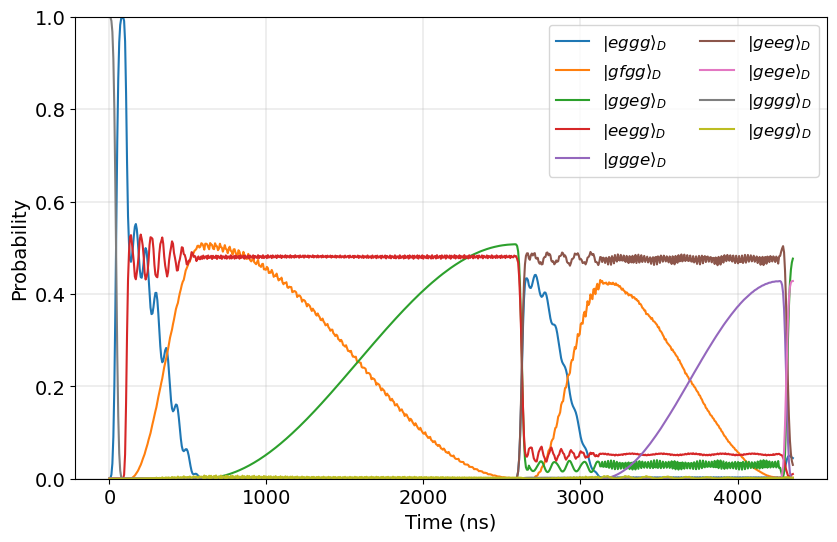

In [16]:
# states for 1 input
eggg = qram.state('eggg')
gfgg = qram.state('gfgg')
ggeg = qram.state('ggeg')
eegg = qram.state('eegg')
ggge = qram.state('ggge')
geeg = qram.state('geeg')
gege = qram.state('gege')
prob_eggg = [np.abs(eggg.overlap(result[t]))**2 for t in range(len(times))]
prob_gfgg = [np.abs(gfgg.overlap(result[t]))**2 for t in range(len(times))]
prob_ggeg = [np.abs(ggeg.overlap(result[t]))**2 for t in range(len(times))]
prob_eegg = [np.abs(eegg.overlap(result[t]))**2 for t in range(len(times))]
prob_ggge = [np.abs(ggge.overlap(result[t]))**2 for t in range(len(times))]
prob_geeg = [np.abs(geeg.overlap(result[t]))**2 for t in range(len(times))]
prob_gege = [np.abs(gege.overlap(result[t]))**2 for t in range(len(times))]

# states for 0 input
gggg = qram.state('gggg')
gegg = qram.state('gegg')
prob_gggg = [np.abs(gggg.overlap(result[t]))**2 for t in range(len(times))]
prob_gegg = [np.abs(gegg.overlap(result[t]))**2 for t in range(len(times))]


plt.plot(times, prob_eggg, label=r'$|eggg\rangle_D$')
plt.plot(times, prob_gfgg, label=r'$|gfgg\rangle_D$')
plt.plot(times, prob_ggeg, label=r'$|ggeg\rangle_D$')
plt.plot(times, prob_eegg, label=r'$|eegg\rangle_D$')
plt.plot(times, prob_ggge, label=r'$|ggge\rangle_D$')
plt.plot(times, prob_geeg, label=r'$|geeg\rangle_D$')
plt.plot(times, prob_gege, label=r'$|gege\rangle_D$')

plt.plot(times, prob_gggg, label=r'$|gggg\rangle_D$')
plt.plot(times, prob_gegg, label=r'$|gegg\rangle_D$')

# plt.plot(times, [np.abs(state('geeg').overlap(result[t]))**2 for t in range(len(times))], 'k--', label=r'$|geeg\rangle_D$')
# plt.plot(times, [np.abs(state('efgg').overlap(result[t]))**2 for t in range(len(times))], 'k-.', label=r'$|efgg\rangle_D$')

# for i1 in range(cutoffs[0]):
#     for i2 in range(cutoffs[1]):
#         for i3 in range(cutoffs[2]):
#             for i4 in range(cutoffs[3]):
#                 # print(qram.levels_nums_to_name([i1, i2, i3, i4]))
#                 plt.plot(times, 
#                          [np.abs(qram.state([i1, i2, i3, i4]).overlap(result[t]))**2 for t in range(len(times))],
#                          label='qram.level_nums_to_name[i1, i2, i3, i4]')

# plt.plot(times, [0.5]*len(times), 'k--', linewidth=0.5)
plt.legend(fontsize=12, ncol=2)
plt.ylim(0, 1)
# plt.xlim(750, 1000)
plt.tick_params(labelsize=14)
plt.xlabel('Time (ns)', fontsize=14)
plt.ylabel('Probability', fontsize=14)
# plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle$')
# plt.title('QRAM state evolution in memory access operation')
plt.grid(linewidth=0.3)
plt.show()

Max fidelity [%]: 42.45486118868793
Final fidelity [%]: 21.142146696817694


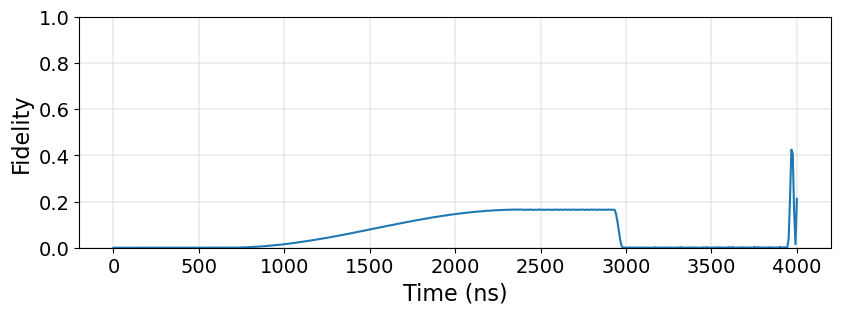

In [38]:
# ket_target = qram.state('ggeg')
ket_target = np.sqrt(0.4) * qram.state('ggeg') + np.sqrt(0.6) * qram.state('gege')
qram.fidelity(qram.state('ggeg'), result[-1])
qram.fidelity(qram.state('gege'), result[-1])

fidelities = [qram.fidelity(ket_target, result[t]) for t in range(len(times))]
print(f'Max fidelity [%]: {1e2*max(fidelities)}')
print(f'Final fidelity [%]: {1e2*fidelities[-1]}')

plt.figure(figsize=(9.7,3))
plt.plot(times, fidelities)

# plt.legend(fontsize=16, ncol=2)
plt.ylim(0, 1)
# plt.xlim(750, 1000)
plt.tick_params(labelsize=14)
plt.xlabel('Time (ns)', fontsize=16)
plt.ylabel('Fidelity', fontsize=16)
# plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle$')
# plt.title('QRAM state evolution in memory access operation')
plt.grid(linewidth=0.3)
plt.show()

Get non zero levels

In [17]:
T = times[-1] # ns

sum_psi = 0
T = np.argmin(np.abs(times-T))
probs = dict()
print("Non-zero levels:")
for i1 in range(cutoffs[0]):
    for i2 in range(cutoffs[1]):
        for i3 in range(cutoffs[2]):
            for i4 in range(cutoffs[3]):
                prob = np.abs(qram.state([i1, i2, i3, i4]).overlap(result[T]))**2
                if prob > 0.01:
                    probs.update({qram.level_nums_to_name([i1, i2, i3, i4]):prob})
                    sum_psi += prob
probs = sorted(probs.items(), key=lambda item:-item[1])
for level, prob in probs:
    print(level, prob)
print('Sum probabilities:', sum_psi)

Non-zero levels:
ggeg 0.4763732008666423
gege 0.4279544555184178
eggg 0.044642048903346165
geeg 0.029995104492812168
eegg 0.010156948694444903
Sum probabilities: 0.9891217584756634


Truncate result so it's compatible with 2q tomography

[[4, 5, 4, 4], [1, 1, 1, 1]]
orig dims [4, 4]
extract state indices [0, 1, 4, 5]
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 6.38717821e-02+0.00000000e+00j  8.62999587e-05-1.70295707e-02j
   1.85486951e-02+2.26514540e-02j  5.13728852e-04-3.79441716e-05j]
 [ 8.62999587e-05+1.70295707e-02j  4.26553684e-01+0.00000000e+00j
  -1.18539807e-01+4.89564960e-03j  3.34102357e-03+4.76130330e-03j]
 [ 1.85486951e-02-2.26514540e-02j -1.18539807e-01-4.89564960e-03j
   5.09324303e-01+0.00000000e+00j  5.28381354e-03-7.90452530e-03j]
 [ 5.13728852e-04+3.79441716e-05j  3.34102357e-03-4.76130330e-03j
   5.28381354e-03+7.90452530e-03j  2.50230961e-04+0.00000000e+00j]]


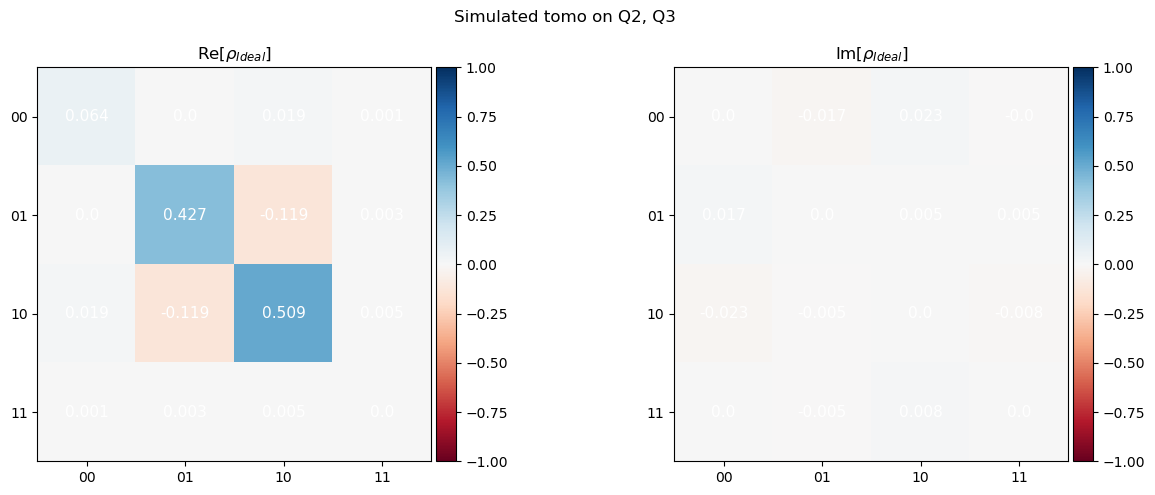

In [18]:
print(result[-1].dims)
tomo_qubits = [2, 3]
result2q = qt.ptrace(result[-1].unit(), tomo_qubits)
orig_dims = result2q.dims[0]
print('orig dims', orig_dims)

states_inds = [i*orig_dims[1]+ j for i in range(2) for j in range(2)]
print('extract state indices', states_inds)
rho_result2q = result2q.extract_states(states_inds, normalize=True)


id2q = qt.tensor(qt.qeye(2), qt.qeye(2))
rho_result2q  = qt.Qobj(rho_result2q , dims=id2q.dims, shape=id2q.shape).unit()
print(rho_result2q)

show_plot_rho_2d(rho_id=rho_result2q.full(), title=f'Simulated tomo on Q{tomo_qubits[0]}, Q{tomo_qubits[1]}', cmax=1.0)

In [12]:
print('want', qram.get_base_wd('eggg', 'gfgg')/2/np.pi)
print('want', qram.get_base_wd('eegg', 'eggg')/2/np.pi)
# print('want', qram.get_wd('eggg', 'gfgg', 0.10, verbose=False)/2/np.pi)
# print('want', qram.get_wd('eegg', 'gfgg', 0.10, verbose=False)/2/np.pi)
# print('want', qram.get_wd('ggge', 'gege', 0.05, verbose=False)/2/np.pi)
# print('resonant to', qram.get_wd('ggeg', 'geeg', 0.05)/2/np.pi)
# print('2 photon transition to', qram.get_base_wd('eggg', 'efgg')/2/np.pi)

want 2.1692639480132065
want 3.6869102975757024
